In [1]:
import collections
import itertools
from IPython.display import Audio, HTML, display

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

from chord_progressions.io.audio import combine_buffers
from chord_progressions.utils import is_circular_match
from chord_progressions.type_templates import get_template_from_template_str
from torch.utils.data import DataLoader
from tqdm import tqdm

from rhythmic_relationships.data import PairDataset

from notebook_utils import (
    get_chroma_vocab,
    get_audio_el,
    mk_voiced_chroma_buffer,
    get_voiced_hits_from_chroma,
)

display(HTML("<style>.container { width:90% !important; }</style>"))

## Load the vocabulary

In [2]:
CHROMA_VOCAB = get_chroma_vocab()
inv_vocab = {v: k for k, v in CHROMA_VOCAB.items()}
stoi = {s: i for i, s in enumerate(inv_vocab)}
itos = {i: s for s, i in stoi.items()}
itot = {ix: i for ix, i in enumerate(list(CHROMA_VOCAB))}
ttoi = {v: k for k, v in itot.items()}

vocab_size = len(CHROMA_VOCAB)
print(f"Vocab size: {vocab_size}")

def get_type_from_template(template):
    for chord_type in list(CHROMA_VOCAB):
        if is_circular_match(
            template,
            get_template_from_template_str(CHROMA_VOCAB[chord_type]),
        ):
            return chord_type
    return None

def pclist_to_i(pclist):
    """Gets a chord type index from a pitch class list
    e.g. pclist_to_i([1,0,0,0,0,0,0,0,0,0,0,0]) -> 1
    """
    chord_type = get_type_from_template(pclist)
    if not chord_type:
        chord_type = "oov"
    template_str = CHROMA_VOCAB[chord_type]
    return stoi[template_str]

Vocab size: 19


## Build the dataset

In [3]:
# Load the dataset
dataset_config = {
    "dataset_name": "babyslakh_20_1bar_4res",
    "part_1": 'Guitar',
    "part_2": 'Piano',
    "repr_1": "chroma",
    "repr_2": "chroma",
}

data = PairDataset(**dataset_config)
loader = DataLoader(data, batch_size=1, shuffle=True)

# How many chords types do we use to predict the next one?
# Do not change from 3 until the code for constructing the context is written more generally
context_length = 3

X, Y = [], []

for x, y in tqdm(loader):
    # Binarize the chromas
    x = (x > 1).to(torch.int32)[0]
    y = (y > 1).to(torch.int32)[0]

    # fill context with silence
    context = [stoi[CHROMA_VOCAB['silence']]] * context_length

    for xrow, yrow in zip(x, y):
        ixx = pclist_to_i(xrow.tolist())
        ixy = pclist_to_i(yrow.tolist())
        # print(','.join(itot[i] for i in context), '-->', itot[ixy])

        X.append(context)
        Y.append(ixy)

        # Hard-code context to length 3 for now
        # TODO: construct the context more generally
        if len(Y[-2:]) < 2:
            context[1:] = [Y[-1]] + [ixx]
            continue
        context = Y[-2:] + [ixx] # the previous 2 Ys and the current X

        # Generally, try to hold an even amount of each, but hold an extra
        # y if the context has an odd length.
        #   e.g. for context length c
        #     n_ys = c // 2 if c % 2 == 0 else c // 2 + 1
        #     n_xs = c // 2


X = torch.tensor(X)
Y = torch.tensor(Y)
n_examples = X.nelement()
print(f'{n_examples=}')
print(X.shape, Y.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1412/1412 [00:06<00:00, 208.41it/s]

n_examples=67776
torch.Size([22592, 3]) torch.Size([22592])


In [4]:
# The classes we create here are the same API as nn.Module in PyTorch
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [107]:
# Bengio et al has a vocab size of 17k and they embed them in a 30-dimensional space
# Our vocab size is much smaller, so we can use a much smaller embedding space

n_embed = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(73709238413)  # for reproducibility

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * context_length, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size, bias=False),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # Make the last layer less confident
    layers[-1].gamma *= 0.1

    # Apply gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(f'num total params: {sum(p.nelement() for p in parameters)}')

num total params: 172028


In [108]:
max_steps = 50000
batch_size = 256
lossi = []
ud = [] # update:data ratio

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    Xb, Yb = X[ix], Y[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_grad

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 40000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

#     if i >= 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization
print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/  50000: 2.9849
  10000/  50000: 0.7603
  20000/  50000: 0.8509
  30000/  50000: 0.8186
  40000/  50000: 0.7767
  49999/  50000: 0.6839


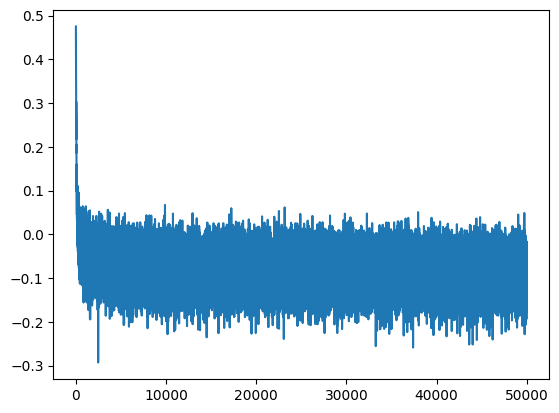

In [116]:
plt.plot(lossi);

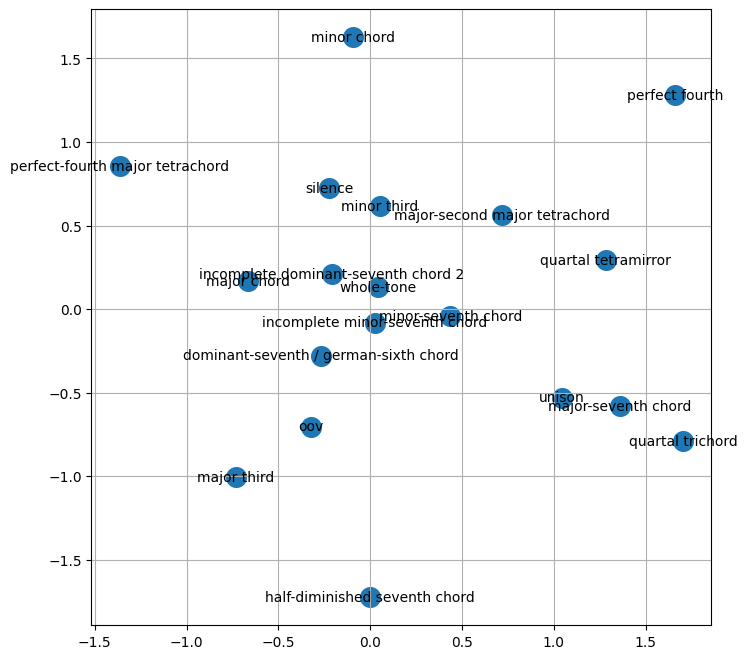

In [117]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itot[i], ha="center", va="center", color='black')
plt.grid('minor')

layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 4.98%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 4.48%
layer 8 (      Tanh): mean +0.00, std 0.67, saturated: 3.88%
layer 11 (      Tanh): mean +0.00, std 0.69, saturated: 3.23%
layer 14 (      Tanh): mean +0.00, std 0.72, saturated: 3.03%


Text(0.5, 1.0, 'activation distribution')

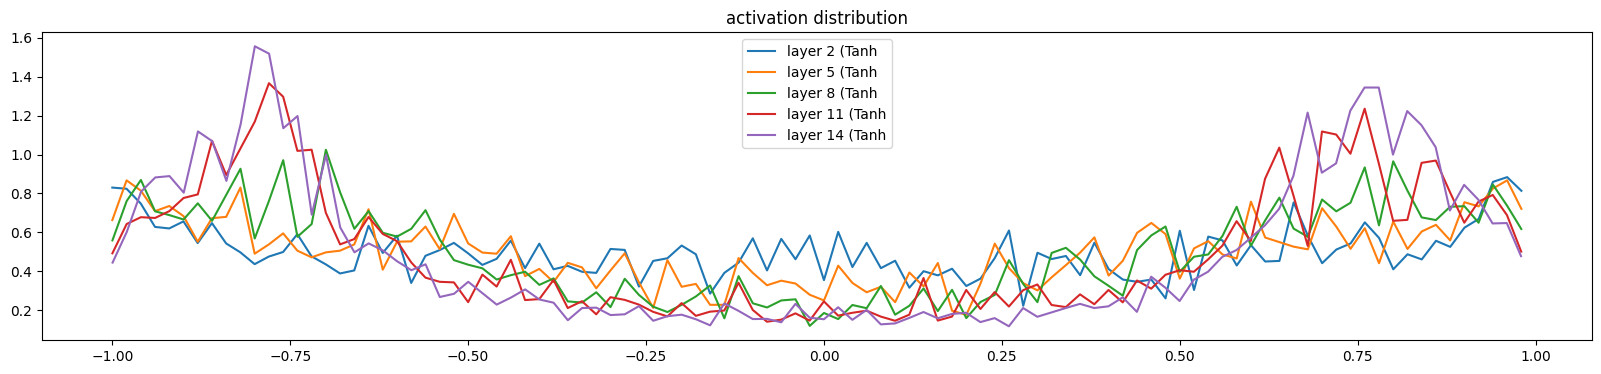

In [118]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.391634e-04
layer 5 (      Tanh): mean +0.000000, std 1.939095e-04
layer 8 (      Tanh): mean +0.000000, std 1.885042e-04
layer 11 (      Tanh): mean -0.000000, std 1.929901e-04
layer 14 (      Tanh): mean -0.000000, std 2.123623e-04


Text(0.5, 1.0, 'gradient distribution')

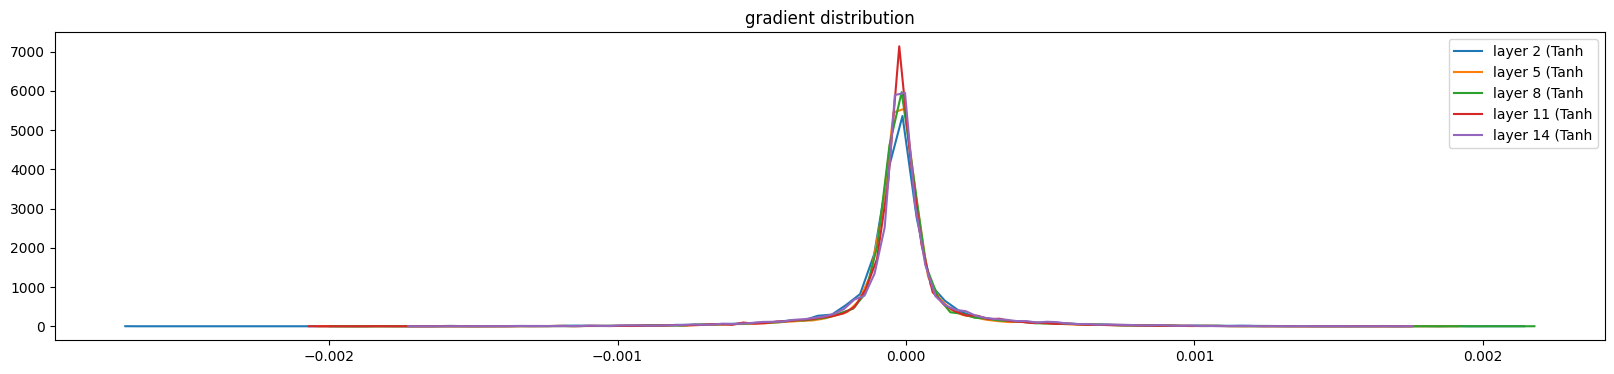

In [119]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (19, 10) | mean +0.000000 | std 3.218133e-03 | grad:data ratio 3.311265e-03
weight  (30, 200) | mean +0.000040 | std 1.506920e-03 | grad:data ratio 5.004122e-03
weight (200, 200) | mean +0.000009 | std 1.086260e-03 | grad:data ratio 8.954337e-03
weight (200, 200) | mean -0.000003 | std 1.094150e-03 | grad:data ratio 9.064404e-03
weight (200, 200) | mean +0.000000 | std 1.054542e-03 | grad:data ratio 8.732065e-03
weight (200, 200) | mean -0.000003 | std 1.050591e-03 | grad:data ratio 8.694148e-03
weight  (200, 19) | mean +0.000008 | std 3.618045e-03 | grad:data ratio 2.419582e-02


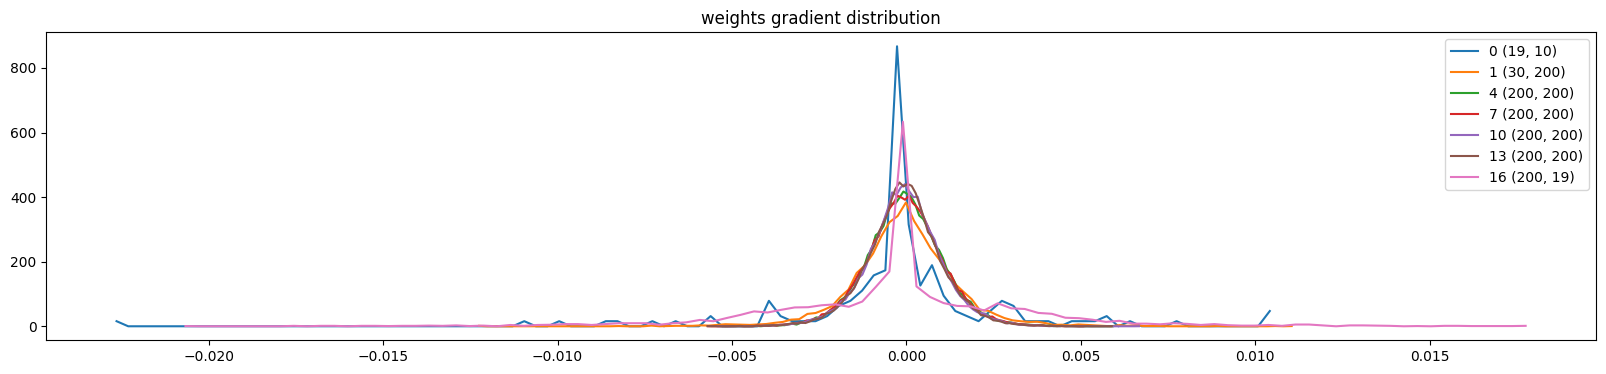

In [120]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

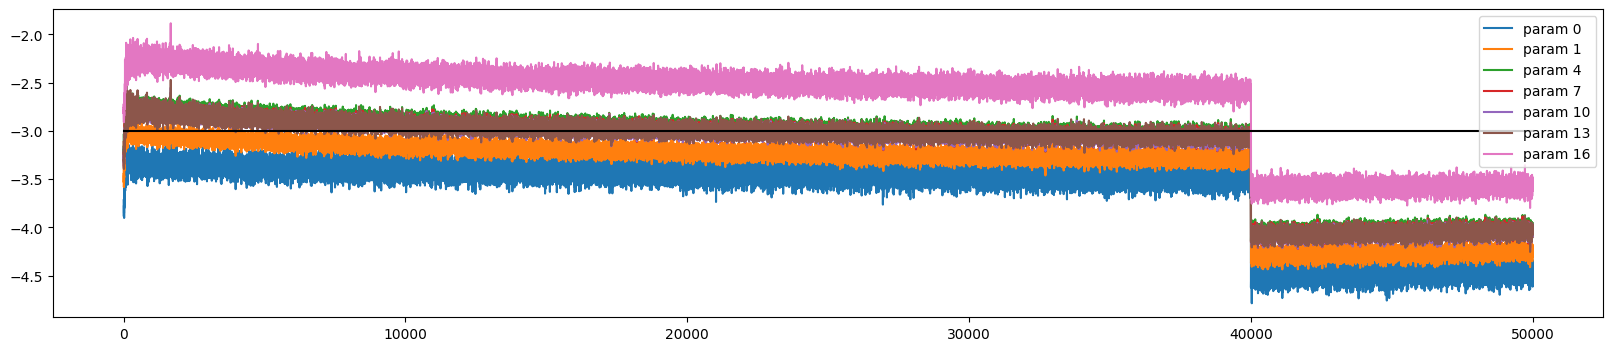

In [121]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### Inference

In [187]:
# Get an examples from the dataset for reference
x, y = next(iter(loader))

# Binarize the chromas
x = (x > 1).to(torch.int32)[0]
y = (y > 1).to(torch.int32)[0]

x_t = []
x_chord_types = []

y_t = []
y_chord_types = []
for xrow, yrow in zip(x, y):
    ixx = pclist_to_i(xrow.tolist())
    ixy = pclist_to_i(yrow.tolist())
    
    x_t.append(ixx)
    y_t.append(ixy)

    x_chord_types.append(itot[ixx])
    y_chord_types.append(itot[ixy])

x_t = [ttoi[''.join(map(str, i))] for i in x_chord_types]
x_chroma = np.array([list(map(int, CHROMA_VOCAB[i])) for i in x_chord_types])
x_voiced_hits = get_voiced_hits_from_chroma(x_chroma)
x_buff = mk_voiced_chroma_buffer(x_voiced_hits, duration=duration, n_overtones=1)
x_hits = (x_chroma.sum(axis=1) > 0).astype(np.int8)

y_chroma = np.array([list(map(int, list(itos[i]))) for i in y_t])
y_hits = (y_chroma.sum(axis=1) > 0).astype(np.int8)
y_voiced_hits = get_voiced_hits_from_chroma(y_chroma)
y_buff = mk_voiced_chroma_buffer(y_voiced_hits, duration=duration, n_overtones=4)

buffs = collections.defaultdict(list)
buffs["".join(map(str, y_hits))].append([y_buff, combine_buffers([x_buff, y_buff])])


html = (
    f'Input {dataset_config["part_1"]}</br>{"".join(map(str, x_hits))}</br>{get_audio_el(x_buff)}'
    + f'</br></br>Predicted {dataset_config["part_2"]}</br></br>Samples from learned distribution'
    + "".join([f"</br>{k}</br>{get_audio_el(v[0][0])}predicted</br>{get_audio_el(v[0][1])}combined" for k, v in buffs.items()])
)

HTML(html)

In [188]:
# disable gradient tracking
@torch.no_grad()
def disable_grads():
    return

# Set layers to eval mode
for layer in layers:
    layer.training = False

# sample from the model
g = torch.Generator().manual_seed(7370923841 + 10)

n_samples = 10
duration = 3  # seconds

input_chord_types = x_chord_types

in_t = [ttoi[''.join(map(str, i))] for i in input_chord_types]

in_chroma = np.array([list(map(int, CHROMA_VOCAB[i])) for i in input_chord_types])
in_voiced_hits = get_voiced_hits_from_chroma(in_chroma)
in_buff = mk_voiced_chroma_buffer(in_voiced_hits, duration=duration, n_overtones=1)
in_hits = (in_chroma.sum(axis=1) > 0).astype(np.int8)

buffs = collections.defaultdict(list)
for _ in range(n_samples):
    out = []

    # We always use the previous 2 Ys and the current X
    context = [stoi[CHROMA_VOCAB['silence']]] * (context_length - 1) + [in_t[0]]

    with torch.no_grad():
        for tix, t in enumerate(in_t):
            # Forward pass the neural net
            embi = C[torch.tensor([context])]
            x = embi.view(embi.shape[0], -1)
            for layer in layers:
                x = layer(x)
            logits = x
            probs = F.softmax(logits, dim=1)

            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            out.append(ix)

            # Shift the context window and track the samples
            if len(out[-2:]) < 2:
                # the prev y and the current x
                context[1:] = [out[-1]] + [t]
                continue
            # the prev 2 Ys and the current X
            context = out[-2:] + [t]

    out_chroma = np.array([list(map(int, list(itos[i]))) for i in out])
    out_hits = (out_chroma.sum(axis=1) > 0).astype(np.int8)
    out_voiced_hits = get_voiced_hits_from_chroma(out_chroma)
    out_buff = mk_voiced_chroma_buffer(out_voiced_hits, duration=duration, n_overtones=4)
    buffs["".join(map(str, out_hits))].append([out_buff, combine_buffers([in_buff, out_buff])])

html = (
    f'Input {dataset_config["part_1"]}</br>{"".join(map(str, in_hits))}</br>{get_audio_el(in_buff)}'
    + f'</br></br>Predicted {dataset_config["part_2"]}</br></br>Samples from learned distribution'
    + "".join([f"</br>{k}</br>{get_audio_el(v[0][0])}predicted</br>{get_audio_el(v[0][1])}combined" for k, v in buffs.items()])
)

HTML(html)